In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
h = 0.6711

def temperature(data):
    BOLTZMANN  = 1.38065e-16         #erg/K - NIST 2010
    PROTONMASS = 1.67262178e-24      #gram  - NIST 2010

    # read internal energy, electron abundance  and star-formation rate
    ne     = data['PartType0/ElectronAbundance'][:]
    energy = data['PartType0/InternalEnergy'][:] #(km/s)^2
    data.close()

    # compute the temperature
    yhelium = 0.0789
    T = energy*(1.0 + 4.0*yhelium)/(1.0 + yhelium + ne)*1e10*(2.0/3.0)
    T *= (PROTONMASS/BOLTZMANN)
    return T
    
def gasTemps(filePathSnap, filePathfof, tag, color):
    with h5py.File(filePathSnap, "r") as data, \
        h5py.File(filePathfof, "r") as f:

        Mgas_all = data["PartType0/Masses"][:] * 1e10 / h

        Mhalo = f["Group/GroupMass"][:] * 1e10 / h #Msun
        #Wind cells count as gas so need to get gas mas in diff way, no GroupMassType
            
        gas_temp = temperature(data) #for whole snapshot 

        HaloMgas = [] 
        HaloColdMass = []
        HaloHotMass = []

        limit = 1e5
            
        numHalos = Mhalo.size
                        
        if tag == "TNG":
            len_h     = f['Group/GroupLen'][:]       #the total number of particles in the halo (gas+dm+stars+black_holes)
            lentype_h = f['Group/GroupLenType'][:] 
            
            for index in range(numHalos):
                data = h5py.File(filePathSnap, "r")

                offset = np.sum(lentype_h[:index], axis=0) #this is the sum of the lengths of all FoF halos previous to the one we consider
                start = offset[0]
                end   = offset[0]+lentype_h[index,0]
                
                Mgas = data["PartType0/Masses"][start:end] * 1e10 / h
                
                HaloMgas.append(np.sum(Mgas)) 
                # appends summed halo gas mass to Mgases for every halo

                coldmass = Mgas[gas_temp[start:end] < limit]
                HaloColdMass.append(np.sum(coldmass))
                
                hotmass = Mgas[gas_temp[start:end] > limit]
                HaloHotMass.append(np.sum(hotmass)) 

                
        
        if tag == "SIMBA":
            len_h = f["Group/GroupLen"][:]
            lentype_h  = f['Group/GroupLenType'][:]   #the number of particles in a halo by particle type
            IDs_h      = f['IDs']['ID'][:]
            IDs_gas = data["PartType0/ParticleIDs"][:]  # all gas particle IDs
            
            Mgas_all = data["PartType0/Masses"][:] * 1e10 / h
            
            for index in range(numHalos):
                start = np.sum(len_h[:index])
                end   = start+len_h[index]
                indexes_h = IDs_h[start:end]
                
                common_indexes, indexes1, indexes2 = np.intersect1d(IDs_gas, indexes_h, assume_unique=False, return_indices=True)
                hMgas = Mgas_all[indexes1]
                
                HaloMgas.append(np.sum(hMgas)) 

                coldmass = hMgas[gas_temp[indexes1] < limit]
                HaloColdMass.append(np.sum(coldmass))
                
                hotmass = hMgas[gas_temp[indexes1] > limit]
                HaloHotMass.append(np.sum(hotmass)) 
                
                # appends summed halo gas mass to Mgases for every halo

        #NOW FINALLY, we have the Halo gas mass w/o wind and split into hot and cold

        plt.scatter(HaloMgas, HaloColdMass, marker = 's', s = 5,  color='blue', label='Cold', alpha=0.6)
        plt.scatter(HaloMgas, HaloHotMass, marker = 'o', s = 5, color='red', label='HOT', alpha=0.6)
            
        plt.xlabel('Halo Gas Mass (Msun)')
        plt.ylabel('Hot or Cold Mass (Msun)')
        plt.title(f'Halo Gass Mass vs Hot and Cold Gas Mass ({tag})')
        plt.legend()
        plt.xscale("log")
        plt.yscale("log")


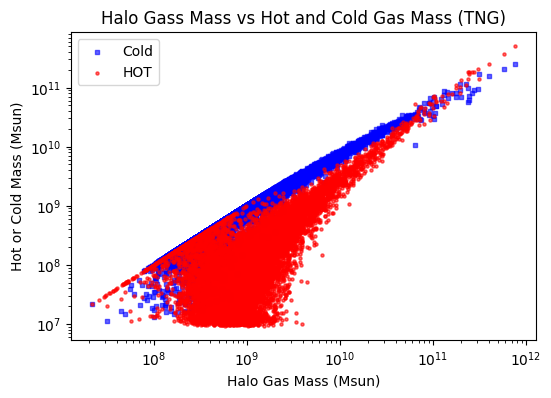

KeyError: "Unable to synchronously open object (object 'ID' doesn't exist)"

<Figure size 600x400 with 0 Axes>

In [4]:
snap_simba_z3 = "data/Output-simba/snap_004.hdf5"
fof_simba_z3  = "data/Output-simba/fof_subhalo_tab_004.hdf5"
snap_tng_z3   = "data/Output-fidTNG/snap_004.hdf5"
fof_tng_z3    = "data/Output-fidTNG/fof_subhalo_tab_004.hdf5"

snap_simba_z0 = "data/Output-simba/snap_032.hdf5" 
fof_simba_z0  = "data/Output-simba/snap_032.hdf5"
snap_tng_z0   = "data/Output-fidTNG/fof_subhalo_tab_032.hdf5"
fof_tng_z0    = "data/Output-fidTNG/fof_subhalo_tab_032.hdf5"

plt.figure(figsize=(6,4))
gasTemps(snap_tng_z3, fof_tng_z3, "TNG", "blue")
plt.show()

plt.figure(figsize=(6,4))
gasTemps(snap_simba_z3, fof_simba_z3, "SIMBA", "red")
plt.show()

In [9]:
import h5py

def print_fof_contents(filename):
    with h5py.File(filename, "r") as f:
        print(f.keys())

        
        print(f['IDs'].keys())


print_fof_contents(fof_simba_z3)


<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>
<KeysViewHDF5 []>
